In [1]:
## IMPORT THE LIBRARIES
import numpy as np
import pandas as pd
import spacy
import json
import re
import os
import nltk
import regex
import gensim
import time
import multiprocessing
import matplotlib.pyplot as plt
from langdetect import detect
from collections import Counter
from nltk import SnowballStemmer
from nltk import ngrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.classify.textcat import TextCat
from collections import defaultdict
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Create object
nlp = spacy.load('en_core_web_sm')
# SET THE DIRECTORY
os.chdir('/Users/SimoneSilvestri/Desktop/OneDrive - Università Commerciale Luigi Bocconi/FIRST YEAR/NATURAL LANGUAGE PROCESSING/MIDTERM PROJECT/FINAL MIDTERM')

### 1.1. Import database
**INPUT DESCRIPTION**: The following dataset contains 250000 tweets downloaded by me on March 17th 2020 with geolocation USA (in the zip file there is also the API I used). I focus only on the “text” column, which contains the entire messages of the tweets, and on "lang" for filtering the language. Since the import and the preprocessing phases are going to take quite a long time to run, I have also prepared a “tweets.xlsx” file with all the preprocessed tweets and an “hashtags.xlsx” file with the hashtags: these two file are imported at point **2.PURPOSE OF THE ANALYSIS**, before the analysis phase.

In [2]:
data = pd.read_json('data_US_2.json')

In [3]:
# Create the initial and new dataset necessary for the comparison of the number of documents, types and tokens
df = data['text']
df = list(df)
# Filtering English tweets
tweets = data.loc[data['lang'] == 'en', 'text']
tweets = list(tweets)
print(len(df),len(tweets))

250000 194968


In [234]:
## Storing all the hashtag words
hashtags = []
for j in tweets:
    hashtag = re.findall(r"#(\w+)",j)
    hashtags.append(hashtag)
hashtags = sum(hashtags,[])
for j in range(len(hashtags)):
    hashtags[j] = hashtags[j].lower()

### 1.2. Preprocessing

In [235]:
## Substitute @USERS
pattern = re.compile('@[A-Za-z0-9_]+')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, '', tweets[j])
    
## Remove URL
pattern = re.compile('https?://[A-Za-z0-9./]+')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, '', tweets[j])
## Remove www    
pattern = re.compile('www.[^ ]+')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, ' ', tweets[j])
    
## Remove punctuation
pattern = re.compile('[^a-zA-Z]')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, ' ', tweets[j])
    
## Remove excess whitespaces
pattern = re.compile(' +')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, ' ', tweets[j])
    tweets[j] = tweets[j].rstrip().lstrip()
    
## All lower case
for j in range(len(tweets)):
    tweets[j] = tweets[j].lower()

## Adjust word with too many character repetitions
pattern = re.compile(r'(.)\1+')
for j in range(len(tweets)):
    tweets[j] = re.sub(pattern, r'\1\1', tweets[j])

## Remove word with lenght equal or less than 3
for j in range(len(tweets)):
    tweets[j] = ' '.join([e for e in tweets[j].split() if len(e) > 3])

In [236]:
## TOKENIZE, LEMMATTIZE, FILTERING
%time df_tokens = [[token.text for token in nlp(sentence)] for sentence in df]
%time tweets_tokens = [[token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in nlp(sentence) if token.pos_ in {'NOUN','VERB', 'PROPN',' ADJ', 'ADV'} and not token.is_stop] for sentence in tweets]

CPU times: user 33min 40s, sys: 8.05 s, total: 33min 48s
Wall time: 33min 50s
CPU times: user 22min 6s, sys: 2.71 s, total: 22min 9s
Wall time: 22min 10s


In [237]:
## Remove additional stopwords
def remove_additional_stopwords(tweets_tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    new_stopwords = ['shit','didn','doesn']
    stopwords.extend(new_stopwords)

    tweets_filtered = [i for i in range(len(tweets_tokens))]
    for i in range(len(tweets_tokens)):
        # Remove stopwords
        tweets_filtered[i] = [e for e in tweets_tokens[i] if not e in stopwords]
        # Remove words less than 3 after all the tranformations
        tweets_filtered[i] = [e for e in tweets_filtered[i] if len(e) >= 3]
        # Unify the tokens
        tweets_filtered[i] = ' '.join(tweets_filtered[i])
         
    return tweets_filtered
        
tweets = remove_additional_stopwords(tweets_tokens)    
# Check that there are no empty rows
tweets = [e for e in tweets if e]   
# Delete (if presented) other duplicates
tweets = list(set(tweets))

### 1.3. Comparison BEFORE and AFTER preprocessing

In [13]:
## SOME STATISTICS
tweets_tokens = [tweet.split() for tweet in tweets]

## df_tokens dataset
# Number of tokens
all_df_tokens = [inner for outer in df_tokens for inner in outer]
num_df_tokens = len(all_df_tokens)
# Number of types
num_df_types = len(set(all_df_tokens))


## tweets_tokens dataset
# Number of tokens
all_tweets_tokens = [inner for outer in tweets_tokens for inner in outer]
num_tweets_tokens = len(all_tweets_tokens)
# Number of types
num_tweets_types = len(set(all_tweets_tokens))

number_documents = [0 for i in range(2)]
number_types = [0 for i in range(2)]
number_tokens = [0 for i in range(2)]
number_documents[0] = len(df_tokens)
number_documents[1] = len(tweets_tokens)
number_types[0] = num_df_types
number_types[1] = num_tweets_types
number_tokens[0] = num_df_tokens
number_tokens[1] = num_tweets_tokens

## PREPROCESSING SUMMMARY
Preprocessing_Statistics = pd.DataFrame(data = [number_documents,number_types,number_tokens], index = ['Documents', 'Types', 'Tokens'], columns = ['Before Preprocessing', 'After Preprocessing'])
Preprocessing_Statistics

,Before Preprocessing,After Preprocessing
Documents,250000,148239
Types,435035,49872
Tokens,2681564,662944


**COMMENT ON THE PREPROCESSING PHASE**: As it can be seen I went through a really strong preprocessed phase: first of all, given the 250000 tweets, I have filtered only the “English” ones (from 250000 to 194968 tweets). Then I have removed “@USER”, “URL”, “WWW”, punctuation and excess whitespaces. Additionally, I have transformed all lower case and I have adjusted words with too many character repetitions (like “wishhhhhhhhhh”, “heeeeeeellllloooooo”, etc.). After many trials I have decided to delete all the words with length less than 3 to reduce even more the variability. Suddenly I have lemmatized substituting “-PRON-“ with the original pronoun and I kept only “NOUN, VERB, PROPN, ADJ and ADV”. Finally I have removed also the stopwords at which I added “shit, didn and doesn”. I decided a so strong preprocessed phase because 
my goal is to bring out only those main topics people talked about on March 17th considering the situation we are going through, so I had to reduce as much as I could the variability in the tweets. Moreover, I have removed negative words like “didn” because my purpose is topic analysis and not sensitivity analysis.

### 1.4. Save all the cleaned texts (tweeets, hashtags)

In [53]:
import xlsxwriter
with xlsxwriter.Workbook('tweets.xlsx') as workbook:
    worksheet = workbook.add_worksheet()
    row = 0
    col = 0
    for tweet in tweets:
        worksheet.write(row , col, tweet)
        row += 1

with xlsxwriter.Workbook('hashtags.xlsx') as workbook:
    worksheet = workbook.add_worksheet()
    row = 0
    col = 0
    for hashtag in hashtags:
        worksheet.write(row , col, hashtag)
        row += 1

**2.PURPOSE OF THE ANALYSIS**: the goal of the investigation concerns the identification of the main topics people are talking about in the US on March 17th 2020. As we know we are going through a difficult period all over the world because of COVID19, and this analysis aims to put in evidence which are the arguments people are dealing with, focusing only on those few topics that people are more care about (if possible around 10 topics) and giving a particular look to covid related words.

In [4]:
## IMPORT THE CLEANED TWEETS
os.getcwd()
tweets = pd.read_excel('/Users/SimoneSilvestri/Desktop/OneDrive - Università Commerciale Luigi Bocconi/FIRST YEAR/NATURAL LANGUAGE PROCESSING/MIDTERM PROJECT/FINAL MIDTERM/3114031/tweets.xlsx',header=None)
tweets = list(tweets[0])
tweets_tokens = [tweet.split() for tweet in tweets]

### 2.1.1. Word embeddings with WORD2VEC
I have chosen word embeddings and not document embeddings because I want to investigate some similarity between words:

In [43]:
## WORD2VEC implementation and train
corpus = tweets_tokens

w2v_model = Word2Vec(size = 200, window = 1, hs = 0, sample = 0.00001, negative = 10, min_count = 1000, workers = -1, iter = 1000)
w2v_model.build_vocab(corpus)
%time w2v_model.train(corpus, total_examples= w2v_model.corpus_count, epochs= w2v_model.epochs)

CPU times: user 2min 2s, sys: 4.18 s, total: 2min 6s
Wall time: 2min 3s


(0, 0)

In [74]:
# WORDS ANALYSIS GIVEN THE SITUATION WE ARE GOING THROUGH
covid = [word[0] for word in w2v_model.wv.most_similar(positive ='covid', topn = 20)]
virus = [word[0] for word in w2v_model.wv.most_similar(positive ='virus', topn = 20)]
coronavirus = [word[0] for word in w2v_model.wv.most_similar(positive ='coronavirus', topn = 20)]
pd.DataFrame(data={'covid':covid, 'virus':virus,'coronavirus':coronavirus})

,covid,virus,coronavirus
0,today,fuck,team
1,team,start,hear
2,close,play,vote
3,take,school,patrick
4,lose,thank,think
5,tell,tonight,fuck
6,home,coronavirus,school
7,tonight,friend,make
8,wait,happen,trump
9,life,game,week


To test the accuracy of the model and the parameters chosen, I focused on three similar words which we know during the current days are similar and often used in the same contexts and see if they are actually recognized as similar. Looking at the top 20 most similar words, it can be seen that they are actually quite closed to each other only setting a high min_count like 1000, as a matter of fact in this scenario there are many words present in more than one of them like coronavirus, virus, school, team, life, etc. Reducing the min_count, the distance between the terms is going to increase (the graph in section 3.1 has min_count = 500).

### 2.1.2. Word embeddings graphical representation

In [32]:
# List of the words of the vocabulary in the word2vec model
words = list(w2v_model.wv.vocab)
# Create a list with all the vectors
words_vectors = [w2v_model.wv[word] for word in words]
# Zip the words with their vector representations
words_zip = zip(words, words_vectors)
# Make a dict to turn into a DataFrame
words_dict = dict(words_zip)
df_words = pd.DataFrame.from_dict(words_dict, orient='index')
df_words.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
mean,-0.001289,0.001801,0.001388,0.000668,-0.000528,0.000822,0.000008,-0.002472,0.002353,-0.001765,...,-0.000255,-0.000485,-0.000730,-0.001420,-0.002223,-0.002021,-0.001039,-0.001379,-0.001745,0.001072
hope,0.000286,-0.001229,0.000222,-0.001114,0.001046,0.001940,-0.000043,0.002365,-0.001582,-0.002317,...,0.001883,-0.001108,-0.001832,0.001418,0.001861,0.001439,0.001664,0.002327,0.001021,0.000174
work,-0.002084,-0.001482,-0.001385,0.000529,-0.000152,0.001744,0.001834,0.001642,0.000537,0.000558,...,-0.002007,0.001642,0.000006,0.002380,0.001655,-0.001530,-0.002420,-0.001252,-0.002449,0.000303
place,0.000112,-0.002045,-0.002072,0.000348,-0.000518,-0.000991,-0.000788,-0.002102,0.000255,-0.001600,...,-0.002450,-0.000263,-0.000422,0.001031,0.000066,0.000312,0.001590,0.001506,-0.001612,-0.002148
people,0.001186,-0.001680,-0.002210,0.002169,-0.002445,-0.001081,-0.002469,0.001720,0.001434,0.002125,...,-0.000538,-0.001037,-0.002288,-0.001931,-0.001130,-0.000846,-0.000968,-0.001193,-0.000118,-0.001627


As can be seen from the scatter plot at point **3.1**, most of the words related to covid and the situation we are going through during these weeks are quite closed together and mainly focus in the center of the scatter plot (with min_count relatively high). The distances change in a relevant way with the perplexity value in the TSNE model; after many trial I found that a perplexity of 50 gives a good representation of what we see when looking the similarity of the word2vec model.

### 2.2.1. Hashtags analysis

In [75]:
## Main used Hashtags
hashtags = pd.read_excel('hashtags.xlsx', header = None)
hashtags = list(hashtags[0])
hash_dict = nltk.FreqDist(hashtags)
hash_rep = pd.DataFrame({'Hashtag': list(hash_dict.keys()), 'Count': list(hash_dict.values())})
hash_rep.sort_values(by = ['Count'], ascending = False, inplace = True)
hash_rep.reset_index(inplace = True)
hash_rep.drop(columns = 'index',inplace = True)
hash_rep.iloc[0:10,:]

,Hashtag,Count
0,coronavirus,845
1,covid19,823
2,stpatricksday,442
3,socialdistancing,345
4,thisisus,283
5,covid2019,197
6,quarantinelife,169
7,clubtwitter,136
8,happystpatricksday,134
9,coronavirusoutbreak,134


There is a strong predominance of tweets with hashtags related to 'coronavirus' and 'stpatrickday' since 17th March is "St. Patrick Day" **(see 3.2 histogram)**, and now I analyse if also the most frequent term are related to these two contexts.

### 2.2.2. Most important terms analysis
After many trials and errors, I found that working with unigrams was difficult on finding the related topics of the main frequent terms, so I have decided to work with manually created bigrams because the results were more interpretable.

In [5]:
## CREATE the BIGRAMS
ngram_corpus = [list(ngrams(sentence.split(),2)) for sentence in tweets]
bigram_corpus = [['_'.join(y) for y in x] for x in ngram_corpus]
bigram_corpus = [e for e in bigram_corpus if e]
tweets_bigrams = [0 for i in range(len(bigram_corpus))]
for i in range(len(bigram_corpus)):
    tweets_bigrams[i] = ' '.join(bigram_corpus[i])

In [ ]:
## Show the 5 most frequent term
%time count = [Counter(t) for t in bigram_corpus]
result2 = sum(count, Counter())
result2.most_common(5)

In [6]:
all_tweets_tokens = [inner for outer in bigram_corpus for inner in outer]


In [15]:
Counter(all_tweets_tokens).most_common()

[('stay_home', 451),
 ('work_home', 431),
 ('toilet_paper', 391),
 ('grocery_store', 240),
 ('look_forward', 205),
 ('wash_hand', 201),
 ('post_photo', 188),
 ('happy_patrick', 173),
 ('humidity_wind', 159),
 ('wind_pressure', 157),
 ('social_distancing', 152),
 ('self_quarantine', 152),
 ('shelter_place', 137),
 ('corn_beef', 136),
 ('spring_break', 135),
 ('thank_share', 119),
 ('come_home', 116),
 ('want_know', 115),
 ('saint_patrick', 109),
 ('make_sense', 108),
 ('need_help', 106),
 ('watch_movie', 104),
 ('click_link', 100),
 ('people_need', 100),
 ('coronavirus_covid', 98),
 ('president_trump', 97),
 ('corona_virus', 97),
 ('health_care', 95),
 ('leave_house', 93),
 ('school_year', 92),
 ('hand_sanitizer', 91),
 ('play_game', 89),
 ('want_work', 88),
 ('donald_trump', 86),
 ('people_think', 85),
 ('spend_time', 84),
 ('live_life', 81),
 ('united_states', 81),
 ('people_know', 81),
 ('think_time', 79),
 ('rand_paul', 78),
 ('tell_people', 78),
 ('home_workout', 77),
 ('couple_day

To analyze the most important terms I implement also simple sparse matrix and TF-IDF: in both cases I leave the default ngram_range = (1,1) since I have already created the bigrams manually but it would be equivalent to set up ngram_range = (2,2); I have tried also with ngram_range = (1,2) but the interpretation was still difficult.

In [19]:
## SPARSE MATRIX representation
vectorizer = CountVectorizer(analyzer='word', min_df= 0.0001, max_df= 0.75) # I worked a lot with the choice of min_df in order to select the best total number of unique bigrams

X = vectorizer.fit_transform(tweets_bigrams)
print(X.shape)

(141429, 1252)


In [22]:
## A look to the 5 most frequent bigrams from the SPARSE MATRIX
vocabulary = vectorizer.vocabulary_
mydict = sorted(vocabulary.items(), key=lambda x: x[1])
mydict = dict(mydict)
B = X.todense()
B = B.sum(axis = 0)
i = 0
for j in mydict.keys():
    mydict[j] = B[0,i]
    i += 1
words = sorted(mydict.items(), key=lambda x: x[1],reverse = True)
words[0:5]

[('stay_home', 451),
 ('work_home', 431),
 ('toilet_paper', 391),
 ('grocery_store', 240),
 ('look_forward', 205)]

In [23]:
## TF - IDF implementation
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', min_df = 0.0001, max_df = 0.75, sublinear_tf=True)
X2 = tfidf_vectorizer.fit_transform(tweets_bigrams)
X.shape, X2.shape

((141429, 1252), (141429, 1252))

In [25]:
## THE 10 MOST RELEVANT BIGRAMS
df = pd.DataFrame(data = {'bigram': vectorizer.get_feature_names(),
                          'tf': X.sum(axis=0).A1,
                          'idf': tfidf_vectorizer.idf_,
                          'tfidf':X2.sum(axis=0).A1
                          })

df = df.sort_values(['tfidf','tf','idf']).reset_index().drop(columns = 'index',axis = 1)
df.head(10)

,bigram,tf,idf,tfidf
0,shower_wednesday,19,9.863828,9.535123
1,button_artisan,19,9.863828,9.985743
2,foodbuttonsbytda_badge,20,9.815038,10.180362
3,play_imessage,15,10.086971,10.227135
4,president_united,15,10.086971,10.710620
5,declare_state,16,10.086971,10.956112
6,chance_shower,24,9.863828,10.998093
7,tomorrow_wednesday,15,10.086971,11.062180
8,buttonsbytda_foodbuttonsbytda,21,9.768518,11.132110
9,work_grocery,16,10.026347,11.203992


At this stage there is a certain coherence with the hashtags analysis since all these bigrams concern the two main topics already emerged. Both simple sparse matrix and TF-IDF are coherent between them.

### 2.3.1. Matrix Factorization vs LDA
The number of topics has been chosen after many trials and errors in matrix factorization and with the additional help of U_mass function for LDA.

#### 2.3.1.1. Matrix Factorization
At the beginnning I worked with unigrams (going from k=5 up to k=50) but the results were really difficult to interpret, so I decided to proceed with bigrams and the findings have been much better. Both SVD and NMF are quite good but NMF performs a little bit better.

In [8]:
## SVD implementation
k = 8 # number of topics CHOSEN THROUGH TRIALS AND ERRORS

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X2)
S = svd.singular_values_
V = svd.components_
print(U.shape, S.shape, V.shape)

(141429, 8) (8,) (8, 1252)


In [9]:
## NMF implementation
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

W = nmf.fit_transform(X2)
H = nmf.components_
print(W.shape, H.shape)

(141429, 8) (8, 1252)


In [10]:
# Find the top 5 words for each latent dimension
def show_topics(A, vocabulary, topn=5):
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [11]:
## SVD Terms
terms = tfidf_vectorizer.get_feature_names()
sorted(show_topics(V, terms))

['grocery_store, work_grocery, store_worker, wash_hand, store_today',
 'happy_patrick, patrick_stpatricksday, corn_beef, social_distancing, thank_share',
 'look_forward, forward_see, self_quarantine, corn_beef, thank_share',
 'post_photo, north_carolina, south_carolina, make_sense, beach_florida',
 'stay_home, home_stay, people_stay, wash_hand, home_week',
 'toilet_paper, buy_toilet, roll_toilet, stay_home, paper_towel',
 'wash_hand, social_distancing, practice_distancing, self_quarantine, look_forward',
 'work_home, stay_home, home_week, home_work, start_work']

In [12]:
## NMF Terms
topn_words = sorted(show_topics(H, terms))
topic = ['store/food','Patrick day','not clear','places/cities','general topics','stay home', 'covid product','work home']
## Given that the NMF terms
main_topics = [ 0 for i in range(len(topn_words))]
for j in range(len(topn_words)):
    main_topics[j] = topn_words[j].replace(',','').split()

In [13]:
## Looking at the words for each topic I have tried to attribute to each category a general name.
main_topics_NMF = pd.DataFrame(data = main_topics).T
main_topics_NMF.rename(columns = {0:'store/food',1:'St. Patrick day',2:'not clear',3:'places/cities',4:'home',5:'covid protections',6:'coronavirus',7:'work home'}, inplace = True)
main_topics_NMF

,store/food,St. Patrick day,not clear,places/cities,home,covid protections,coronavirus,work home
0,grocery_store,happy_patrick,look_forward,post_photo,stay_home,toilet_paper,wash_hand,work_home
1,work_grocery,social_distancing,forward_see,north_carolina,home_stay,buy_toilet,social_distancing,home_week
2,store_worker,patrick_stpatricksday,social_distancing,south_carolina,people_stay,roll_toilet,self_quarantine,home_work
3,store_today,corn_beef,thing_look,beach_florida,home_week,paper_towel,practice_distancing,start_work
4,grocery_shopping,beef_cabbage,walk_stage,international_airport,home_work,hand_sanitizer,stay_inside,people_work


#### 2.3.1.2. LDA with gensim
Even with LDA I began with unigrams but due to the difficulties found in the interpredation of the output, I went along as well with bigrams:

In [31]:
dictionary = Dictionary(bigram_corpus)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below = 50, no_above=0.75) ## really strong term frequency reduction applied
print(dictionary, flush=True)

Dictionary(125 unique tokens: ['grocery_store', 'watch_movie', 'stay_home', 'think_people', 'people_die']...)


In [32]:
ldacorpus = [dictionary.doc2bow(text) for text in bigram_corpus]
#ldacorpus = [e for e in ldacorpus if e]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

In [33]:
## CHOOSE THE NUMBER OF TOPICS
coherence_values = []
model_list = []

dev_size = 10000 # subset of the data where we are training
eval_size = 5000 # subset of the data where we evaluate

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], id2word=dictionary, num_topics=num_topics)
    
    model_list.append(model)
    
    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=bigram_corpus[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    
    print(num_topics, umass_score)
    coherence_values.append((num_topics, umass_score))

5 -19.319101951906426
6 -19.40962177246681
7 -19.135425745021827
8 -18.743405025630658
9 -19.267095545946468
10 -19.07818548854467
11 -19.26967935916055
12 -19.16385302199424
13 -18.948544811596037
14 -18.887437843543005
15 -18.804227519474107


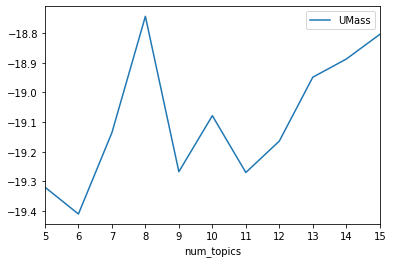

In [34]:
# In this case increasing the size of the dictionary, more topics U_mass saggests
import matplotlib.pyplot as plt
%matplotlib inline

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])
scores.plot.line(x='num_topics', y='UMass', xticks=range(5,16));

For the LDA_model I set an alpha low because looking at the words distribution over tweets in **section 3.3**, it can be said that the major part of tweets has only one topic.

In [37]:
num_topics = 8 # chosen through trials and errors and through U_mass function working with few token in the dictionary
               # Increasing the size of the dictionary the output interpretation starts reducing.

num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, corpus=model_corpus, id2word=dictionary, workers=min(4, multiprocessing.cpu_count()-1), 
                     passes=num_passes, chunksize=chunk_size, alpha=0.01, eta = 'auto')
    
print("done in {}".format(time.time()-start), flush=True)

7071.45
fitting model
done in 41.88637018203735


In [38]:
# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep,'', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=10)]
# Create a list of list of topics
list_topics = [[0 for j in range(len(model_topics[i][1]))] for i in range(len(model_topics))]
for i in range(len(model_topics)):
    list_topics[i][0] = model_topics[i][1][0].replace('"','')
    j = 1
    for j in range(len(model_topics[i][1])):
        list_topics[i][j]= model_topics[i][1][j].replace('"','')
        j +=1
# Create a dataframe for better visualization
df_topics_gensim = pd.DataFrame(data = list_topics).T 
df_topics_gensim.columns = ['Topic '+str(i) for i in range(len(list_topics))]
df_topics_gensim ## this time I didn't give a name to each of them because they look mixed

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,humidity_wind,corn_beef,stay_home,know_people,toilet_paper,happy_patrick,look_forward,work_home
1,wind_pressure,come_home,self_quarantine,time_time,wash_hand,thank_share,post_photo,grocery_store
2,school_year,click_link,leave_house,video_game,shelter_place,want_know,social_distancing,practice_distancing
3,think_time,president_trump,spend_time,covid_coronavirus,spring_break,people_need,coronavirus_covid,health_care
4,self_isolation,saint_patrick,people_think,think_people,hand_sanitizer,make_sense,play_game,live_life
5,ask_friend,watch_movie,know_need,watch_video,need_help,tell_people,liquor_store,people_know
6,couple_week,corona_virus,work_tomorrow,people_want,take_care,time_year,wanna_know,work_hour
7,stay_away,want_work,know_want,need_stop,bernie_sander,animal_crossing,donald_trump,rand_paul
8,spend_money,united_states,love_one,sign_petition,birthday_rosie,home_workout,hope_stay,school_close
9,student_loan,confirm_case,rest_year,port_portland,think_thing,watch_time,rest_semester,start_tomorrow


Similar bigrams to NMF appeared but they seem mixed together; increasing the size of the dictionary and the number of topics (or modifying them in an interactive way), greater is the confusion **(see section 3.4 comparison importance vs bigrams frequency in the LDA model)**. In this analysis, the NMF model performs better than LDA and this happen because tweets are really short messages, and a frequency term analysis gives better results.

#### 2.3.1.3. LDA with sklearn
Additionaly I have tried to implement LDA with sklearn to see if there was an improvement but the results are still not clear as  in NMF:

In [39]:
## LDA from simple sparce matrix
lda_tf = LatentDirichletAllocation(n_components = 8, n_jobs = -1)
lda_tf.fit(X)
# LDA from TF-IDF matrix
lda_tfidf = LatentDirichletAllocation(n_components = 8, n_jobs = -1)
lda_tfidf.fit(X2)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [40]:
# LDA from TF-IDF
def show_topics(vectorizer, lda_model, n_words):
    words = np.array(vectorizer.get_feature_names())
    topic_words = []
    for topic in lda_model.components_:
        top_words_locs = (-topic).argsort()[:n_words]
        topic_words.append(words.take(top_words_locs))
    return topic_words

topic_words = show_topics(vectorizer=tfidf_vectorizer, lda_model=lda_tfidf, n_words=10)
# dataframe for better visualization
df_topic = pd.DataFrame(topic_words).T
df_topic.columns = ['Topic '+str(i) for i in range(len(topic_words))]
df_topic  

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,toilet_paper,post_photo,happy_patrick,want_know,grocery_store,stay_home,work_home,look_forward
1,watch_movie,need_help,social_distancing,saint_patrick,thank_share,shelter_place,corn_beef,wash_hand
2,leave_house,corona_virus,spring_break,health_care,make_sense,come_home,coronavirus_covid,self_quarantine
3,come_soon,live_life,humidity_wind,united_states,president_trump,hand_sanitizer,donald_trump,people_need
4,support_business,rand_paul,wind_pressure,want_work,play_game,spend_time,bernie_sander,couple_week
5,ask_friend,know_know,people_think,take_care,home_workout,practice_distancing,know_need,sign_petition
6,send_love,school_close,school_year,tell_people,thing_happen,couple_day,think_thing,animal_crossing
7,white_house,think_people,click_link,know_people,work_hard,need_stop,people_vote,happy_patty
8,group_chat,student_loan,think_time,try_time,rest_semester,get_work,people_work,love_love
9,help_people,time_year,people_know,super_bowl,wanna_know,birthday_rosie,beef_cabbage,know_time


### 2.3.2. Additional unigram visualization with pyLDAvis (NOT NECESSARY)
Unigram interactive visualization:

In [41]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

X3 = vectorizer.fit_transform(tweets) # the vectorizer has been previously defined

lda_output = lda_tf.fit_transform(X3)

pyLDAvis.sklearn.prepare(lda_tf, X3, vectorizer, mds='tsne')

/Users/SimoneSilvestri/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5        2.719570 -171.562576       1        1  13.489862
6     -119.684135 -126.767235       2        1  13.103869
3     -160.978333   -3.138522       3        1  13.045831
4       39.645138  118.974739       4        1  12.467097
7      -11.974160  -22.076847       5        1  12.457408
1      -90.073776  106.232117       6        1  12.076948
2      130.496323   25.511959       7        1  11.813790
0      114.057137 -103.790054       8        1  11.545195, topic_info=     Category         Freq    Term        Total  loglift  logprob
2231  Default  5465.000000    know  5465.000000  30.0000  30.0000
2407  Default  4562.000000    love  4562.000000  29.0000  29.0000
4374  Default  3766.000000    want  3766.000000  28.0000  28.0000
4122  Default  6416.000000    time  6416.000000  27.0000  27.0000
2386  Default  3285.000000    look  3285.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
4077   Topic8   609.282238   thank  3851.730939   0.3149  -4.6681
4092   Topic8   544.856001   think  4590.555659   0.0277  -4.7798
2929   Topic8   519.057087  people  4963.353379  -0.0989  -4.8283
809    Topic8   431.358606    come  3510.635864   0.0623  -5.0134
1638   Topic8   417.355612  friend  1941.478540   0.6216  -5.0464

[507 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
18        6  0.996636   account
18        7  0.002940   account
34        6  0.998559  actually
41        8  0.988880   address
70        2  0.046251     agree
...     ...       ...       ...
4515      5  0.073498      year
4515      7  0.000328      year
4517      7  0.989216      yell
4534      2  0.004867      zoom
4534      4  0.992864      zoom

[1058 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 5, 8, 2, 3, 1])

### 2.4.1. Clustering word embeddings with KMeans + PCA for dimensionality reduction

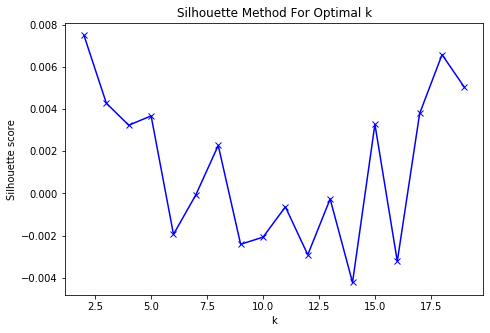

In [44]:
# silhouette_score on unigrams
K = range(2,20)
score = []
for c in K:
    clusterer = KMeans(n_clusters = c,n_jobs = -1)
    preds = clusterer.fit_predict(w2v_model.wv.vectors)
    centers = clusterer.cluster_centers_
    
    score.append(silhouette_score(w2v_model.wv.vectors, preds))

fig, ax = plt.subplots(figsize=(7.5,5))
plt.plot(K, score, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [53]:
k = 8 ## in coherence with the previous topic choices and with silhouette score
km = KMeans(n_clusters = k, init='k-means++', n_jobs = -1, max_iter=100)
clusters = km.fit_predict(w2v_model.wv.vectors)
labels = km.labels_.tolist()
centroids = km.cluster_centers_
# For the graph representation look at section 3.5
pca = PCA(n_components=3).fit(w2v_model.wv.vectors)
datapoint = pca.transform(w2v_model.wv.vectors)
centroidpoint = pca.transform(centroids)
df_datapoint = pd.DataFrame(data={'x':datapoint[:,0], 'y': datapoint[:,1], 'z': datapoint[:,2]})
df_centroids = pd.DataFrame(data={'x':centroidpoint[:,0], 'y': centroidpoint[:,1], 'z': centroidpoint[:,2]})
df_datapoint['label'] = labels

In [55]:
# Show the top 10 terms for each cluster
from sklearn.neighbors import KDTree
def words_unigrams(index = w2v_model.wv.index2word, k = 10, centroids = centroids, vectors = w2v_model.wv.vectors):
    tree = KDTree(vectors)
    # Get the 10 most closest points
    near_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centroids]
    near_words = [x[1] for x in near_points]
    words = {}
    for i in range(0, len(near_words)):
        words['Topic ' + str(i)] = [index[j] for j in near_words[i][0]]
    # dataframe from dictionary
    df = pd.DataFrame(words)
    df.index = df.index + 1
    return df
words_unigrams()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
1,place,life,covid,wanna,care,say,know,thing
2,take,home,lose,vote,house,school,thank,live
3,make,covid,time,quarantine,live,tomorrow,year,month
4,play,think,think,read,tell,family,wait,try
5,want,quarantine,right,look,month,team,check,fuck
6,get,right,love,miss,year,money,week,stay
7,kid,try,girl,today,lose,lose,vote,talk
8,think,watch,need,day,time,hour,hope,lose
9,look,say,coronavirus,money,vote,call,live,hear
10,bitch,school,work,stop,quarantine,break,think,trump


Look at section **3.5** for the cluster 3D plot with centroidpoints.

### 2.4.2. Clustering bigrams with KMeans

In [59]:
km = KMeans(n_clusters = 8, n_jobs = -1) ## number of cluster chosen mainly through trials and errors but with also a look at silhouette score
clusters_KMeans = km.fit_predict(X2)
centroids_KMeans = km.cluster_centers_

In [60]:
# Show the top 10 words for each cluster
def words_bigrams(data, clusters, labels, k):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    topics_dict = {}
    for i,r in df.iterrows():
        topics_dict[i] = [labels[t] for t in np.argsort(r)[-k:]]
    return topics_dict
            
topics_clusters_KMeans = words_bigrams(X2, clusters_KMeans, tfidf_vectorizer.get_feature_names(), 10)
pd.DataFrame(data = topics_clusters_KMeans).rename(columns = {0:'Topic 1',1:'Topic 2',2: 'Topic 3', 3: 'Topic 4',4:'Topic 5',5:'Topic 6',6:'Topic 7',7:'Topic 8'})

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,want_know,money_come,city_council,thank_ask,know_people,think_leave,friend_work,home_watch
1,corn_beef,health_crisis,covid_case,finally_time,bar_close,today_look,try_figure,need_stay
2,thank_share,totally_forget,love_song,corn_beef,close_day,know_look,grocery_store,wash_hand
3,shelter_place,work_class,stay_indoor,quarantine_work,taco_bell,couple_day,foot_pic,home_work
4,spring_break,work_tomorrow,stop_laugh,stay_home,world_end,good_news,security_guard,stay_stay
5,happy_patrick,work_company,happy_patrick,wash_hand,need_time,time_look,hand_sanitizer,tell_stay
6,wash_hand,wanna_come,wash_hand,understand_people,world_right,walk_stage,paper_towel,home_week
7,post_photo,work_home,self_quarantine,quarantine_want,make_sense,thing_look,roll_toilet,people_stay
8,grocery_store,work_today,living_room,quarantine_start,tampa_buccaneer,forward_see,buy_toilet,home_stay
9,work_home,come_work,social_distancing,self_quarantine,brady_tampa,look_forward,toilet_paper,stay_home


### 2.4.3. Clustering bigrams with MiniBatchKMeans

In [61]:
clusters_MiniBatch = MiniBatchKMeans(n_clusters=8, init='k-means++', n_init=1024, batch_size=2048).fit_predict(X2)

In [62]:
topics_clusters_MiniBatch = words_bigrams(X2, clusters_MiniBatch, tfidf_vectorizer.get_feature_names(), 10)
pd.DataFrame(data = topics_clusters_MiniBatch).rename(columns = {0:'Topic 1',1:'Topic 2',2: 'Topic 3', 3: 'Topic 4',4:'Topic 5',5:'Topic 6',6:'Topic 7',7:'Topic 8'})

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,want_know,today_thank,city_council,people_home,know_know,take_shower,home_today,home_watch
1,corn_beef,time_thank,covid_case,want_quarantine,know_happen,try_figure,home_time,need_stay
2,shelter_place,love_people,love_song,tell_stay,know_girl,grocery_store,home_quarantine,wash_hand
3,spring_break,people_coronavirus,stay_indoor,coronavirus_covid,know_get,foot_pic,get_work,home_work
4,self_quarantine,wish_best,stop_laugh,try_stay,know_love,security_guard,people_work,stay_stay
5,happy_patrick,kind_word,happy_patrick,need_stay,kansas_city,hand_sanitizer,tell_work,tell_stay
6,wash_hand,hope_family,wash_hand,walk_away,rain_humidity,paper_towel,start_work,home_week
7,look_forward,stream_tonight,self_quarantine,want_stay,cloud_humidity,roll_toilet,home_work,people_stay
8,post_photo,love_thank,living_room,get_stay,wind_pressure,buy_toilet,home_week,home_stay
9,grocery_store,thank_share,social_distancing,stay_away,humidity_wind,toilet_paper,work_home,stay_home


**COMMENT ON CLUSTERING**: as concerns words embeddings clustering, the interpretation is not immediate, but the overall words dynamics concern the coronavirus context and the St. Patrick Day, while as concerns bigrams clustering, both KMean and MiniBatchKMeans work pretty well, better the LDA. I have chosen 8 topics through trials and errors and also in coherence with the previous analysis, but even more topics, with some subjective considerations, work reasonably as well.

### 3.1. Word embeddings representation in a 2D scatter plot with TSNE
Graphical representation of word embeddings using TSNE for dimensionality reduction. It gives a more sensible idea of what is going on when running a word2vec model.

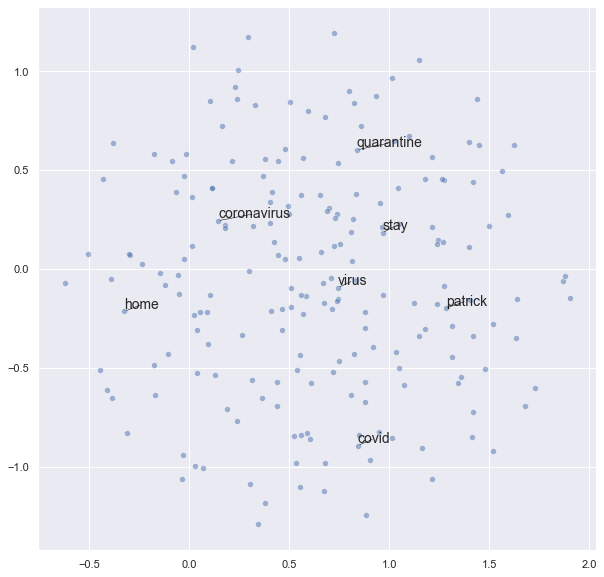

In [158]:
from sklearn.manifold import TSNE
import seaborn as sns
from adjustText import adjust_text
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
wv_tsne = tsne.fit_transform(df_words)
## words list for the plot
words_plot = []
words_list = ['coronavirus','covid','virus','patrick','home','stay','quarantine']
for word in words_list:
    words_plot.append(df_words.index.get_loc(word))
# PLOT OF THE WORDS DISTANCE AFTER HAVING REDUCE THE DIMENSIONALITY OF THE WORD VECTORS FROM WORD2VEC WITH TSNE
sns.set()
fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(wv_tsne[:, 0], wv_tsne[:, 1], alpha = 0.5)

texts = []

# Append the selected words to texts
for word in words_plot:
    texts.append(plt.text(wv_tsne[word, 0], wv_tsne[word, 1], df_words.index[word], fontsize = 14))
    
# Plot the words on the scatter plot (an alternative was using annotate)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### 3.2. Hastaghs representation
Just a simple look to the most important topics:

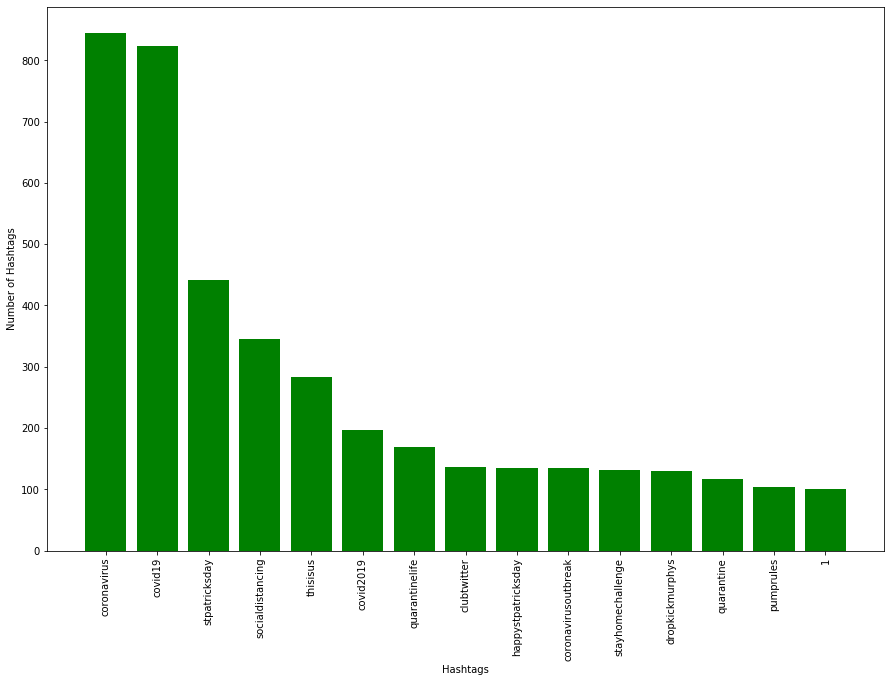

In [76]:
## Histogram of the hashtags
fig, ax = plt.subplots(figsize = (15, 10))
ax.bar(hash_rep.Hashtag[0:15], hash_rep.Count[0:15], color='green')
ax.set_xlabel('Hashtags')
ax.set_xticklabels(hash_rep.Hashtag[0:15], rotation=90)
ax.set_ylabel('Number of Hashtags')
plt.show()

### 3.3. Distribution of Characters and Words over tweets

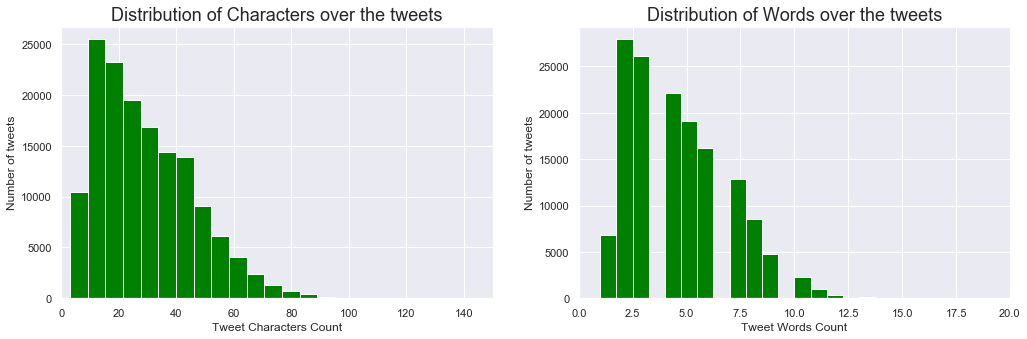

In [195]:
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('Distribution of Characters over the tweets',fontdict=dict(size=18))
character_counts = [len(e) for e in tweets]

ax.hist(character_counts, bins = 20, color='green')
ax.set(xlim=(0, 150), ylabel='Number of tweets', xlabel='Tweet Characters Count')

ax = axs[1]
ax.set_title('Distribution of Words over the tweets',fontdict=dict(size=18))

word_counts = [len(e) for e in tweets_tokens]

ax.hist(word_counts, bins = 20, color='green')
ax.set(xlim=(0, 20), ylabel='Number of tweets', xlabel='Tweet Words Count')

plt.show()

### 3.4. Bar plot with the most important bigrams for each topic (LDA) vs count bigrams
As can be seen, importance is not the same of frequence in the LDA model:

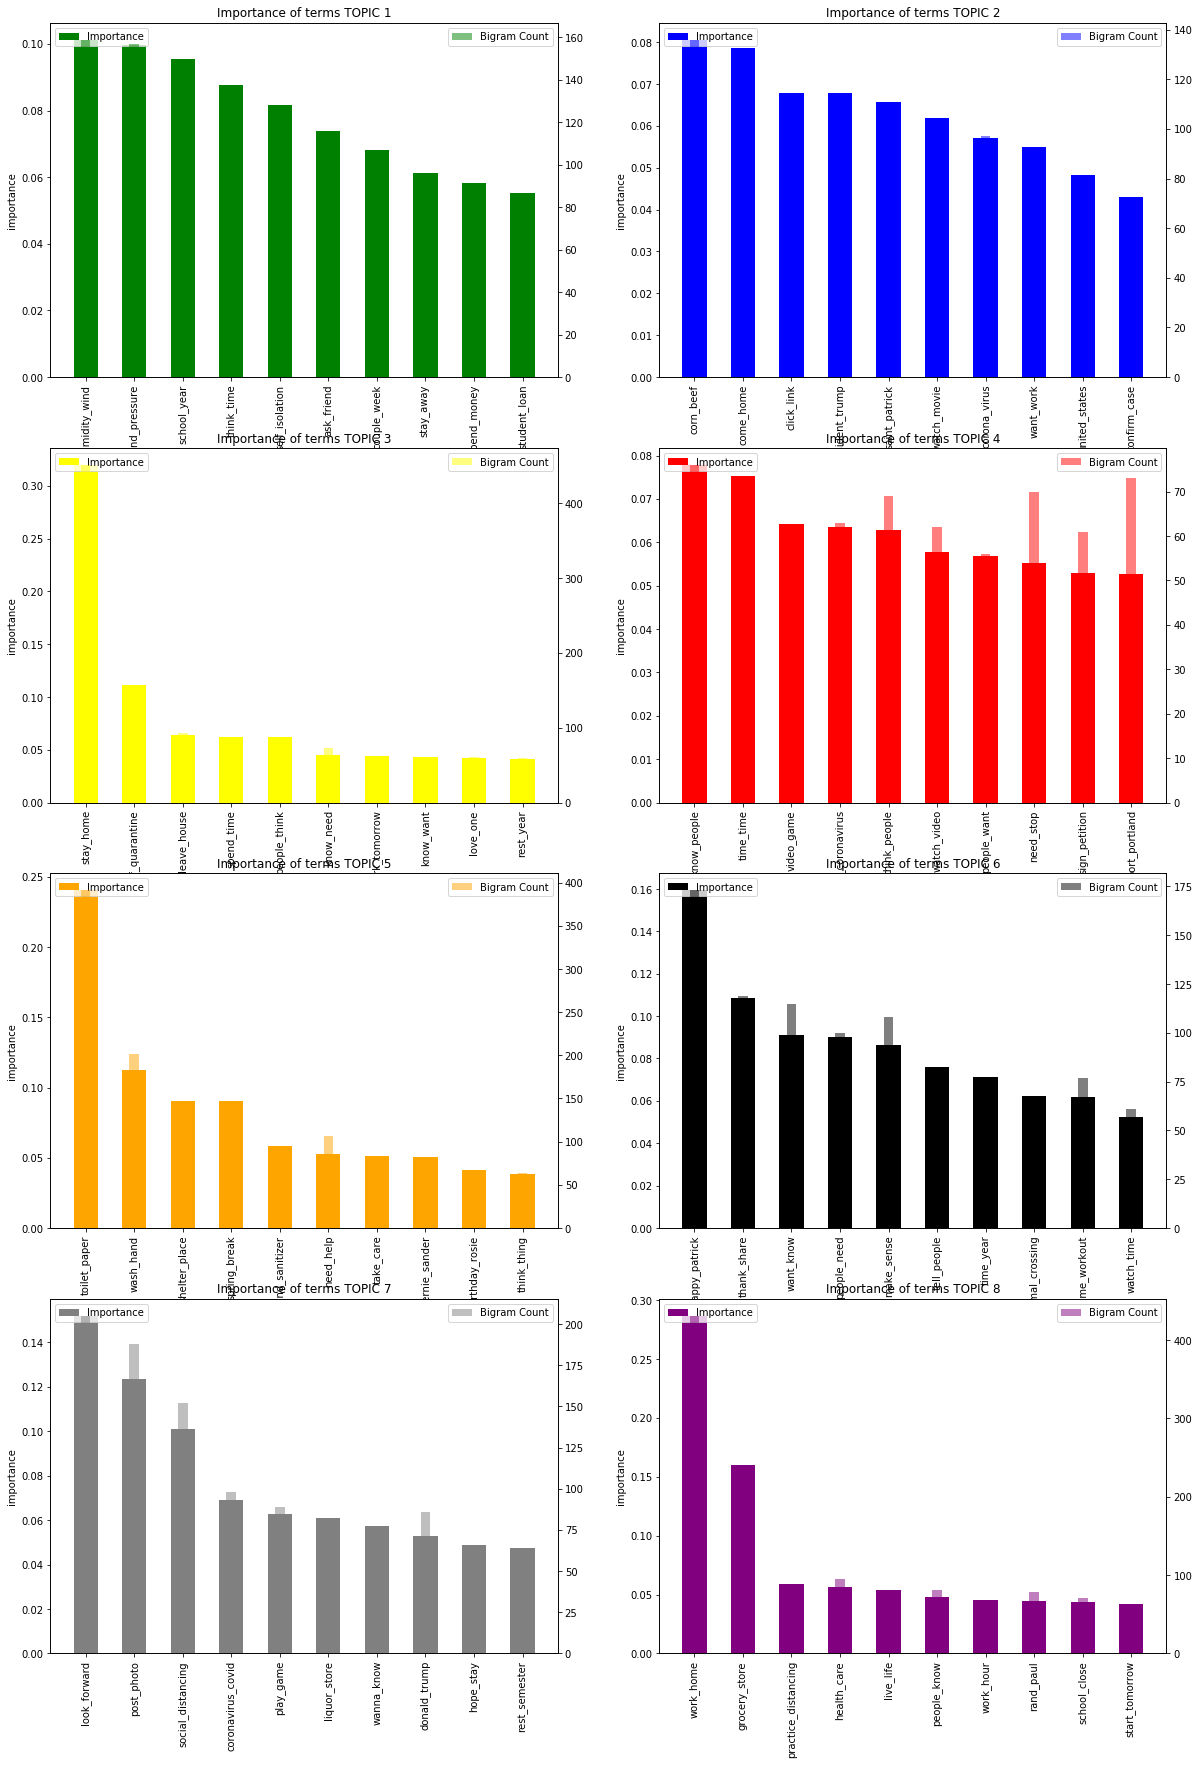

In [58]:
## lda_model summary
from collections import Counter
lda_topics = model.show_topics(formatted=False)
lda_result = [e for word in bigram_corpus for e in word]
counter = Counter(lda_result)
lda_summary = []
for i, topic in lda_topics:
    for word, weight in topic:
        lda_summary.append([word, i , weight, counter[word]])
df_lda_summary = pd.DataFrame(data = lda_summary, columns=['bigram', 'topic number', 'importance', 'bigram count'])

## PLOT THE BIGRAMS WITH THE RELATIVE IMPORTANCE FOR EACH TOPIC
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(20,30))

ax = axs[0,0]
ax.set_title('Importance of terms TOPIC 1',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==0, :], color='green',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==0, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==0, :], color='green', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[0,1]
ax.set_title('Importance of terms TOPIC 2',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==1, :], color='blue',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==1, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==1, :], color='blue', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[1,0]
ax.set_title('Importance of terms TOPIC 3',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==2, :], color='yellow',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==2, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==2, :], color='yellow', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[1,1]
ax.set_title('Importance of terms TOPIC 4',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==3, :], color='red',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==3, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==3, :], color='red', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[2,0]
ax.set_title('Importance of terms TOPIC 5',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==4, :], color='orange',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==4, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==4, :], color='orange', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[2,1]
ax.set_title('Importance of terms TOPIC 6',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==5, :], color='black',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==5, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==5, :], color='black', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[3,0]
ax.set_title('Importance of terms TOPIC 7',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==6, :], color='grey',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==6, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==6, :], color='grey', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

ax = axs[3,1]
ax.set_title('Importance of terms TOPIC 8',color = 'black', fontdict=dict(size=12))

ax.bar(x='bigram', height="importance", data=df_lda_summary.loc[df_lda_summary['topic number']==7, :], color='purple',width=0.5, label='Importance')
ax.set_xticklabels(df_lda_summary.loc[df_lda_summary['topic number']==7, 'bigram'], rotation=90)
ax_twin = ax.twinx()
ax_twin.bar(x='bigram', height="bigram count", data=df_lda_summary.loc[df_lda_summary['topic number']==7, :], color='purple', width=0.2, alpha = 0.5, label='Bigram Count')
ax.set_ylabel('importance')
ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

plt.show()

### 3.5. Word embeddings KMeans representation
Word embeddings clustering representation having used PCA as dimensionality reduction algorithm intead of TSNE:

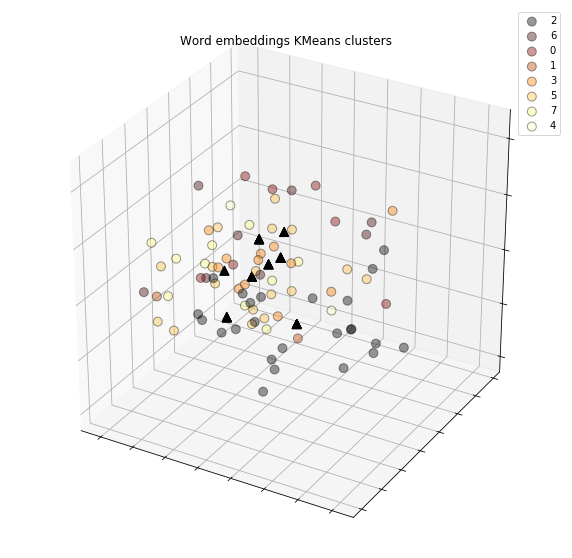

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
cm = plt.get_cmap('afmhot') # choose the color palette
n_labels = len(df_datapoint.label.unique())
label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
cMap = colors.ListedColormap(label_colors)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
frame1 = plt.gca() 

frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

# plot each label as scatter plot in its own color
for l, label in enumerate(df_datapoint.label.unique()):
    df2 = df_datapoint[df_datapoint.label == label]
    color_values = [label_colors[l]] * len(df2)
    ax.scatter(df2['x'], df2['y'], df2['z'], 
                c=color_values, 
                cmap=cMap, 
                edgecolor='black', 
                label=label, 
                alpha=0.4, 
                s=80)
    ax.scatter(df_centroids['x'], df_centroids['y'], df_centroids['z'],
               c = 'black',
               marker='^',
               s = 80)
    
plt.title('Word embeddings KMeans clusters')
plt.legend()
plt.show()

**FINAL COMMENT**: I have decided of leaving word2vec with unigrams while the other models with bigrams in order to have a sort of parallel analysis. Overall speaking, it can be said that through the topics analysis it is emerged that the main terms are related to two big area: "coronavirus" and "St. Patrick Day". Inside these two macroareas the greatest part of tweets concerns "store/food","stay home/related activities", "covid protections", "general covid situation + campaign", "work home" and "places/cities". I have decided on focusing only in the major trends but a deeper and broadly analysis could have been made, for example working with 50/100 topics.